In [1]:
%load_ext autoreload
%autoreload 2

# python
import os
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use("ATLAS")
import pandas as pd
import sys
sys.path.append("../")

# custom
import Utils as ut
from Utils import loadALEPH2004Result, loadWeights, ensembleWeights, calc_hist, plotThrust
import dataloader

In [2]:
aleph = ut.loadALEPH2004Result()
print(aleph["aleph_log_thrust_errs"])
print(aleph["aleph_log_thrust_errs"] - np.linalg.norm(aleph["aleph_log_thrust_errs_individual"], axis=1))
print(print(aleph["log_bins_min"]))

THRUST,THRUST LOW,THRUST HIGH,(1/SIG)*D(SIG)/DTHRUST,stat +,stat -,sys_1 +,sys_1 -,sys_2 +,sys_2 -
[0.00144485 0.00761793 0.01701719 0.00781693 0.00746136 0.00677942
 0.00814534 0.0077546  0.0070463  0.00968856 0.00883575 0.00875478
 0.00948643 0.00881046 0.00790756 0.00968362 0.00909576 0.0086974
 0.0068823  0.00685199 0.00751772 0.00534918 0.00509836 0.00535912
 0.00636601 0.00561443 0.00563602 0.00609543 0.00640759 0.00483177
 0.00531451 0.00450477 0.00354568 0.00293204 0.00207306 0.00221681
 0.00172053 0.00111097 0.00080795 0.00057632 0.00050214 0.00029193]
[ 0.00000000e+00  0.00000000e+00  3.46944695e-18  0.00000000e+00
 -8.67361738e-19  0.00000000e+00  1.73472348e-18 -8.67361738e-19
 -8.67361738e-19  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.73472348e-18
  1.73472348e-18 -1.73472348e-18  0.00000000e+00  8.67361738e-19
 -8.67361738e-19  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.000000

/global/u1/b/badea/aleph/unfold-ee-logtau/Plotting/Utils.py:114: RuntimeWarning: divide by zero encountered in log
  aleph_log_bins = np.log(aleph_bins)


In [3]:
# Load the data
import json
with open("../training_conf.json") as f:
      training_conf = json.load(f)
reco_data, reco_mc, gen_mc, pass_reco, pass_gen = dataloader.DataLoader(training_conf)
# flatten
reco_data = reco_data.flatten()
reco_mc = reco_mc.flatten()
gen_mc = gen_mc.flatten()
print(reco_data.shape, reco_mc.shape, gen_mc.shape, pass_reco.shape, pass_gen.shape)
# apply selection
reco_mc = reco_mc[pass_reco]
gen_mc = gen_mc[pass_gen] # fully efficient
print(reco_mc.shape, gen_mc.shape)

(1365440,) 1326312
(771597,) 751861
(1326312,) (973769,) (973769,) (973769,) (973769,)
(751861,) (973769,)


In [4]:
# load alternative theory predictions
import sys
sys.path.append("../ReweightMC")
import ReweightMCDataLoading as rmc
theory_gen_mc = {}
for key, val in rmc.mc_paths.items():
    theory_gen_mc[key] = rmc.loadData(
        filePath = val["path"],
        treeName = val["tree"],
        branches = ["Thrust"],
    )
    theory_gen_mc[key] = np.log(1-theory_gen_mc[key]).flatten()
    print(key, theory_gen_mc[key].shape)

2025-07-28 11:06:12.503291: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753725972.640633 1502062 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753725972.683464 1502062 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753725972.987173 1502062 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753725972.987217 1502062 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753725972.987220 1502062 computation_placer.cc:177] computation placer alr

ArchivedMC (973769,)
Pythia8 (500000,)
Herwig (4999984,)
Sherpa (5000000,)


In [5]:
N = 10

# # analysis note review 1 results
# ensemble = "/global/homes/b/badea/aleph/unfold-ee-logtau/results/training-745de56e/*/model_weights*" # Nominal result
# # ensemble = "/global/homes/b/badea/aleph/unfold-ee-logtau/results/training-d6b08785/*/model_weights*" # gen cleaning
# ensemble_weights = ensembleWeights(loadWeights(ensemble), N=N)
# print(ensemble_weights.shape)

# systematic = "/global/homes/b/badea/aleph/unfold-ee-logtau/results/training-439c81ff/*/model_weights*"
# systematic_weights = ensembleWeights(loadWeights(systematic), N=N)
# print(systematic_weights.shape)

# theory = "/global/u1/b/badea/aleph/unfold-ee-logtau/results/training-65d965a4/*/model_weights*"
# theory_weights = ensembleWeights(loadWeights(theory), N=N)
# print(theory_weights.shape)

# # analysis note review 2 results
# filePath = "/pscratch/sd/b/badea/aleph/unfold-ee-logtau/UniFold/results/training-e583e610" # first round
filePath = "/pscratch/sd/b/badea/aleph/unfold-ee-logtau/UniFold/results/training-df4a6ec5" # second round
filePath = os.path.join(filePath, "*/*/conf.json")
w = ut.loadWeightPaths(filePath)
for key, val in w.items():
    for k, v in val.items():
        w[key][k] = ensembleWeights(loadWeights(v), N=N)
        print(key, k, len(v), w[key][k].shape)

# make keys
ensemble_weights = w["Ensembling"]["nominal"]
systematic_weights_order = ['ntpc7', 'pt04', 'ech10', 'no_neutrals', 'with_met']
systematic_weights = np.concatenate([w["Systematics"][k] for k in systematic_weights_order], axis=0)
theory_weights_order = ["Pythia8", "Sherpa", "Herwig"]
theory_weights = np.concatenate([w[f"TheoryUncertainty_{k}"]["nominal"] for k in theory_weights_order], axis=0)
bootstrap_weights_data = w["BootstrapData"]["nominal"]
bootstrap_weights_mc = w["BootstrapMC"]["nominal"]

Ensembling nominal 100 (1, 10, 973769)
Systematics pt04 12 (1, 1, 973769)
Systematics with_met 12 (1, 1, 973769)
Systematics ntpc7 12 (1, 1, 973769)
Systematics ech10 12 (1, 1, 973769)
Systematics no_neutrals 12 (1, 1, 973769)
BootstrapMC nominal 40 (1, 4, 973769)
TheoryUncertainty_Sherpa nominal 12 (1, 1, 973769)
BootstrapData nominal 40 (1, 4, 973769)
TheoryUncertainty_Herwig nominal 12 (1, 1, 973769)
TheoryUncertainty_Pythia8 nominal 12 (1, 1, 973769)
ClosureTest nominal 4 (1, 0, 973769)


In [ ]:
def subdivide_bins(bin_edges, N):
    new_edges = []
    for i in range(len(bin_edges)-1):
        start = bin_edges[i]
        end = bin_edges[i+1]
        # Create N equally spaced points inside each bin
        subdivided = np.linspace(start, end, N+1)[:-1]  # exclude last to avoid duplicates
        new_edges.extend(subdivided)
    # Append the last original bin edge to close the last bin
    new_edges.append(bin_edges[-1])
    return np.array(new_edges)

import math
dr = [math.log(0.06), math.log(0.25)] # dijet region used for thrust fit https://indico.cern.ch/event/1512328/attachments/3011747/5310355/Vita_Feb_2025.pdf
# customBins = list(np.linspace(aleph["log_bins_min"], -6, 1, endpoint=False)) 
# customBins += list(np.linspace(-6, -4.5, 3, endpoint=False)) 
# customBins += list(np.linspace(-4.5, dr[0], 50, endpoint=False))
# customBins += list(np.linspace(dr[0], dr[1], 50, endpoint=False))
customBins = list(np.linspace(aleph["log_bins_min"], -5, 3, endpoint=False)) 
customBins += list(np.linspace(-5, dr[1], 200, endpoint=False))
customBins += list(np.linspace(dr[1], math.log(0.5), 40, endpoint=True))
customBins = np.array(customBins)

# plotting configuration
conf = {
    # "logtau" : {
    #     "aleph" : {
    #         "x" : aleph["aleph_log_midbins"], 
    #         "y": aleph["aleph_log_thrust"], 
    #         "xerr": aleph["aleph_log_binwidths"]/2, 
    #         "yerr": aleph["aleph_log_thrust_errs"], 
    #         "bins" : aleph["aleph_log_bins"],
    #     },
    #     "ax1_ylabel" : r"1/$\sigma$ d$\sigma$/d$\log(\tau)$",
    #     "ax1_yscale" : "log",
    #     "ax2_xscale" : "linear",
    #     "ax1_ylim" : [0.2*10**-5, 10**0],
    #     "ax2_xlabel" : r"$\log(\tau)$", # "log(1-T)",
    #     "ax2_ylim" : [0.01, 1.99],
    #     "bins" : aleph["aleph_log_bins"],
    #     "legend" : "lower right",
    #     "legend_bbox" : (0.98, 0.0)
    # },
    "logtau" : {
        "aleph" : {
            "x" : aleph["aleph_log_midbins"], 
            "y": aleph["aleph_log_thrust"], 
            "xerr": aleph["aleph_log_binwidths"]/2, 
            "yerr": aleph["aleph_log_thrust_errs"], 
            "bins" : aleph["aleph_log_bins"],
        },
        "ax1_ylabel" : r"1/$\sigma$ d$\sigma$/d$\log(\tau)$",
        "ax1_yscale" : "log",
        "ax2_xscale" : "linear",
        "ax1_ylim" : [0.2*10**-5, 10**0],
        "ax2_xlabel" : r"$\log(\tau)$", # "log(1-T)",
        "ax2_ylim" : [0.01, 1.99],
        # "bins" : subdivide_bins(aleph["aleph_log_bins"], N=2), # aleph log bins split into N bins each
        "bins" : customBins,
        "legend" : "lower right",
        "legend_bbox" : (0.98, 0.0)
    },
    # "thrust" : {
    #     "aleph" : {
    #         "x" : aleph["aleph_midbins"], 
    #         "y": aleph["aleph_thrust"], 
    #         "xerr": aleph["aleph_binwidths"]/2, 
    #         "yerr": aleph["aleph_thrust_errs"], 
    #         "bins" : aleph["aleph_bins"]
    #     },
    #     "ax1_ylabel" : r"1/$\sigma$ d$\sigma$/d(1-T)",
    #     "ax1_yscale" : "log",
    #     "ax2_xscale" : "linear",
    #     "ax1_ylim" : [0.3*10**-3, 4*10**1],
    #     "ax2_xlabel" : "1-T",
    #     "ax2_ylim" : [0.68, 1.32],
    #     "bins" : np.linspace(0, 0.45, 51),
    #     "legend" : "lower left",
    #     "legend_bbox" : (0.05, 0.0)
    # }
}    

In [7]:
import math

dr = [math.log(0.06), math.log(0.25)]
# Count number of points in customBins within the region defined by dr
count = np.sum((aleph["aleph_log_bins"] >= dr[0]) & (aleph["aleph_log_bins"] <= dr[1]))
print("Number of aleph points dijet in region:", count)
count = np.sum((customBins >= dr[0]) & (customBins <= dr[1]))
print("Number of custom points in region:", count)
print(customBins)

Number of aleph points dijet in region: 20
Number of custom points in region: 79
[-6.         -5.66666667 -5.33333333 -5.         -4.98193147 -4.96386294
 -4.94579442 -4.92772589 -4.90965736 -4.89158883 -4.8735203  -4.85545177
 -4.83738325 -4.81931472 -4.80124619 -4.78317766 -4.76510913 -4.74704061
 -4.72897208 -4.71090355 -4.69283502 -4.67476649 -4.65669796 -4.63862944
 -4.62056091 -4.60249238 -4.58442385 -4.56635532 -4.5482868  -4.53021827
 -4.51214974 -4.49408121 -4.47601268 -4.45794415 -4.43987563 -4.4218071
 -4.40373857 -4.38567004 -4.36760151 -4.34953299 -4.33146446 -4.31339593
 -4.2953274  -4.27725887 -4.25919034 -4.24112182 -4.22305329 -4.20498476
 -4.18691623 -4.1688477  -4.15077917 -4.13271065 -4.11464212 -4.09657359
 -4.07850506 -4.06043653 -4.04236801 -4.02429948 -4.00623095 -3.98816242
 -3.97009389 -3.95202536 -3.93395684 -3.91588831 -3.89781978 -3.87975125
 -3.86168272 -3.8436142  -3.82554567 -3.80747714 -3.78940861 -3.77134008
 -3.75327155 -3.73520303 -3.7171345  -3.6990

In [8]:
# make histograms
plots = {}
for key, val in conf.items():
    plots[key] = {}
    for binType in ["nominal", "aleph"]:
        bins = val["bins"] if binType == "nominal" else val["aleph"]["bins"]
        # data histograms
        plots[key][f"data_{binType}"] = calc_hist(reco_data, bins=bins, density=True) # = counts_data, errors_data, bin_edges
        # mc reco histograms
        plots[key][f"mc_reco_{binType}"] = calc_hist(reco_mc, bins=bins, density=True)
        # gen before histograms
        plots[key][f"mc_genBefore_{binType}"] = calc_hist(gen_mc, bins=bins, density=True)
        # theory comparison plots
        for theory, theory_mc in theory_gen_mc.items():
            plots[key][f"{theory}_{binType}"] = calc_hist(theory_mc, bins=bins, density=True)
        # unifold histograms
        for iW, weights in enumerate(np.squeeze(ensemble_weights, axis=0)):
            plots[key][f"unifold_{binType}_ensemble{iW}"] = calc_hist(gen_mc, bins=bins, density=True, weights=weights.flatten())
        for iW, weights in enumerate(systematic_weights):
            plots[key][f"unifold_{binType}_systematic{iW}"] = calc_hist(gen_mc, bins=bins, density=True, weights=weights.flatten())
        for iW, weights in enumerate(theory_weights):
            plots[key][f"unifold_{binType}_theory{iW}"] = calc_hist(gen_mc, bins=bins, density=True, weights=weights.flatten())
        for iW, weights in enumerate(np.squeeze(bootstrap_weights_data, axis=0)):
            plots[key][f"unifold_{binType}_bootstrapData{iW}"] = calc_hist(gen_mc, bins=bins, density=True, weights=weights.flatten())
        for iW, weights in enumerate(np.squeeze(bootstrap_weights_mc, axis=0)):
            plots[key][f"unifold_{binType}_bootstrapMC{iW}"] = calc_hist(gen_mc, bins=bins, density=True, weights=weights.flatten())

In [9]:
errors = {}
for key, val in conf.items():
    errors[key] = {}
    for binType in ["nominal", "aleph"]:
        
        # bins
        bins = val["bins"] if binType == "nominal" else val["aleph"]["bins"]
        binwidths = bins[1:] - bins[:-1]
        bin_centers = (bins[:-1] + bins[1:]) / 2
        
        # style
        style = {
            "legend_loc" : val["legend"],
            "legend_bbox" : val["legend_bbox"],
            "legend_ncol" : 2,
            "legend_fontsize" : 11,
            "ax1_ylabel" : val["ax1_ylabel"],
            "ax1_yscale" : val["ax1_yscale"],
            "ax2_xlabel" : val["ax2_xlabel"],
            "ax2_xscale" : val["ax2_xscale"],
            "ax2_ylabel" : f'Ratio to\nNominal',
            "ax1_ylim" : val["ax1_ylim"],
            "bins" : bins,
            "ax2_ylim" : val["ax2_ylim"],
        }

        # pick up nominal
        nominal = plots[key][f"unifold_{binType}_ensemble0"]

        # inPlots
        inPlots = {}
        systList = [
            # ["ensemble", 0], #ensemble_weights.shape[1]],
            ["systematic", systematic_weights.shape[0]],
            ["theory", theory_weights.shape[0]]
        ]
        # define list for all errors
        # err = []

        # define lists for systematic errors and theory errors
        systematic_err = []
        theory_err = []
        for systType, iWRange in systList:
            for iW in range(iWRange):
                inPlots[f"unifold_{binType}_{systType}{iW}"] = {
                    "plotType": "errorbar", 
                    "x": bin_centers, 
                    "y": plots[key][f"unifold_{binType}_{systType}{iW}"][0], 
                    "color": None, 
                    "label": f"{systType.title()} {iW}", 
                    "xerr": binwidths/2, 
                    "yerr": plots[key][f"unifold_{binType}_{systType}{iW}"][1]
                }
                if systType == "systematic":
                    systematic_err.append(nominal[0] - plots[key][f"unifold_{binType}_{systType}{iW}"][0])
                if systType == "theory":
                    theory_err.append(nominal[0] - plots[key][f"unifold_{binType}_{systType}{iW}"][0])
        
        # compute totals
        total_exp_systematic_err = np.sqrt(np.sum(np.stack(systematic_err,axis=1)**2, axis=1)) # take the sum in quadrature
        print(total_exp_systematic_err.shape)
        
        # compute total theory error. take the value with the largest absolute value, but keep its original sign
        print(np.stack(theory_err,axis=1).shape)
        theory_stack = np.stack(theory_err, axis=1)
        idx = np.argmax(np.abs(theory_stack), axis=1)
        total_theory_err = theory_stack[np.arange(theory_stack.shape[0]), idx]
        print(total_theory_err.shape)

        # get the ensemble uncertainty
        ensemble_err = []
        for iW in range(1, ensemble_weights.shape[1]): # don't include the nominal setting
            ensemble_err.append(plots[key][f"unifold_{binType}_ensemble{iW}"][0])
        ensemble_err = np.array(ensemble_err)
        total_ensemble_err = np.std(ensemble_err, axis=0) # take std over the errors
        # if total_ensemble_err.shape != nominal[1].shape:
        #     print(f"Total ensemble error was: {total_ensemble_err}. So setting the total ensemble error to zero")
        #     total_ensemble_err = np.zeros(nominal[1].shape)
        
        # bootstrap uncertainty
        bootstrap_data_err = np.std(np.array([plots[key][f"unifold_{binType}_bootstrapData{iW}"][0] for iW in range(bootstrap_weights_data.shape[1])]), axis=0)
        bootstrap_mc_err = np.std(np.array([plots[key][f"unifold_{binType}_bootstrapMC{iW}"][0] for iW in range(bootstrap_weights_mc.shape[1])]), axis=0)

        # build the full uncertainty
        err_list = [
            ["Stat. (w/o Bootstraps)", list(nominal[1])],
            ["Ensemble", list(total_ensemble_err)],
            ["Bootstrap Data", list(bootstrap_data_err)],
            ["Bootstrap MC", list(bootstrap_mc_err)],
            [["NTPC", "Track pT", "Charged Energy", "Thrust w/o Neutrals", "Thrust w/ MissP"], systematic_err],
            ["Max Theory", list(total_theory_err)]
        ]
        individualErrorLabelOrder, err = [], []
        for i, j in err_list:
            if isinstance(i, list):
                individualErrorLabelOrder.extend(i)
                err.extend(j)
            else:
                individualErrorLabelOrder.append(i)
                err.append(j)

        # stack and sum in quadrature
        err = np.stack(err, axis=1) 
        print("Error shapes: ", err.shape)
        total_err = np.sqrt(np.sum(err**2, axis=1))

        # create entry for the errors
        errors[key][f"unifold_{binType}_ensemble0"] = {
            "total" : total_err, 
            "individual" : err,
            "nominal_stat_uncertainty" : nominal[1],
            "total_exp_systematic_error" : total_exp_systematic_err,
            "total_theory_error" : total_theory_err,
            "theory_errors" : np.stack(theory_err, axis=1),
            "total_ensemble_error" : total_ensemble_err,
            "bootstrap_data_err" : bootstrap_data_err, 
            "bootstrap_mc_err" : bootstrap_mc_err,
        }

        # plot
        inPlots["unifold"] = {"plotType": "errorbar", "x": bin_centers, "y": nominal[0], "color": "black", "label": "Unifold", "xerr":binwidths/2, "yerr":total_err}
        
        # ratio denominator using the total error
        ratio_denom = [[nominal[0], total_err, nominal[2]]]

        # fig, (ax1, ax2) = plotThrust(style, inPlots, ratio_denom, epsilon = 1e-10)
        # plt.show()
        # plt.close()

(212,)
(212, 3)
(212,)
Error shapes:  (212, 10)
(42,)
(42, 3)
(42,)
Error shapes:  (42, 10)


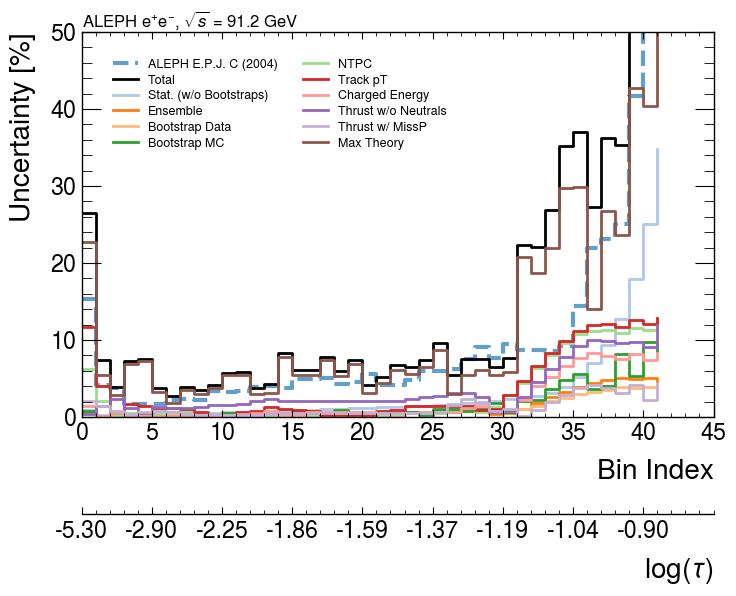

In [10]:
import itertools

def plotArange(z, doThis=True):
    return np.arange(len(z)) if doThis else z

theoryOnly = False
key = "logtau"
pname = "unifold_aleph_ensemble0"
nominal = plots[key][pname]
bins = conf[key]["aleph"]["bins"] if "aleph" in pname else conf[key]["bins"] 
bin_centers = (bins[:-1] + bins[1:]) / 2


divide = True
ylabel = "Uncertainty [%]" if divide else "Error" # "Error/Bin Content"

# plot
fig, ax = plt.subplots(figsize=(8, 5))
# Use a color cycle from matplotlib that doesn't repeat for the number of error components
colors = plt.cm.tab20.colors  # 20 unique colors
color_cycle = itertools.cycle(colors)

if not theoryOnly:
    ax.step(plotArange(conf[key]["aleph"]["x"]), conf[key]["aleph"]["yerr"] / conf[key]["aleph"]["y"] * 100, where='post', label="ALEPH E.P.J. C (2004)", color=next(color_cycle), linestyle="--", lw=3, alpha=0.7)
    ax.step(plotArange(bin_centers), errors[key][pname]["total"]/nominal[0]*100 if divide else errors[key][pname]["total"], where='post', label="Total", color="black")   

if theoryOnly:
    theory_errors = np.abs(errors[key][pname]["theory_errors"])
    for i, label in enumerate(theory_weights_order):
        ax.step(plotArange(bin_centers), theory_errors[:, i]/nominal[0]*100 if divide else theory_errors[:, i], where='post', label=label, color=next(color_cycle))
        next(color_cycle)  # skip color for theory only

individual = np.abs(errors[key][pname]["individual"])
for i, label in enumerate(individualErrorLabelOrder):
    color = next(color_cycle)
    if theoryOnly: 
        if label == "Max Theory": 
            color="black"
        else:
            continue
    ax.step(plotArange(bin_centers), individual[:, i]/nominal[0]*100 if divide else individual[:, i], where='post', label=label, color=color)

# Add a secondary x-axis showing the actual bin values
secax = ax.secondary_xaxis('bottom')
# Only show ticks and tick labels for the bins that have tick labels on the first x axis
main_xticks = ax.get_xticks()
main_xticklabels = [item.get_text() for item in ax.get_xticklabels()]
# Find the bin centers that match the main axis ticks
sec_ticks = []
sec_ticklabels = []
for tick, label in zip(main_xticks, main_xticklabels):
    # Only keep ticks that are within the range of bin_centers
    if tick in plotArange(bin_centers):
        idx = int(tick)
        if 0 <= idx < len(bin_centers):
            sec_ticks.append(idx)
            sec_ticklabels.append(f"{bin_centers[idx]:.2f}")
secax.set_xticks(sec_ticks)
secax.set_xticklabels(sec_ticklabels)
secax.spines['bottom'].set_position(('outward', 70))  # move secondary axis 30 points below
secax.set_xlabel(r"$\log(\tau)$")

ax.set_xlabel("Bin Index") # $\log(\tau)$ 
ax.set_ylabel(ylabel)
# ax.set_yscale("log")
# ax.set_ylim(5*10**-5, 2*10**2)
ax.set_ylim(0, 50)
ax.text(0, 1, r"ALEPH e$^{+}$e$^{-}$, $\sqrt{s}$ = 91.2 GeV", transform=ax.transAxes, ha='left', va='bottom', fontsize=12)
ax.legend(ncol=2, fontsize=15 if theoryOnly else 9, bbox_to_anchor=(0.02, 0.98), loc="upper left")
outName = "logtau_unifold_uncertainty_TheoryComparison.pdf" if theoryOnly else "logtau_unifold_uncertainty.pdf"
plt.savefig(outName, bbox_inches='tight')
plt.show()

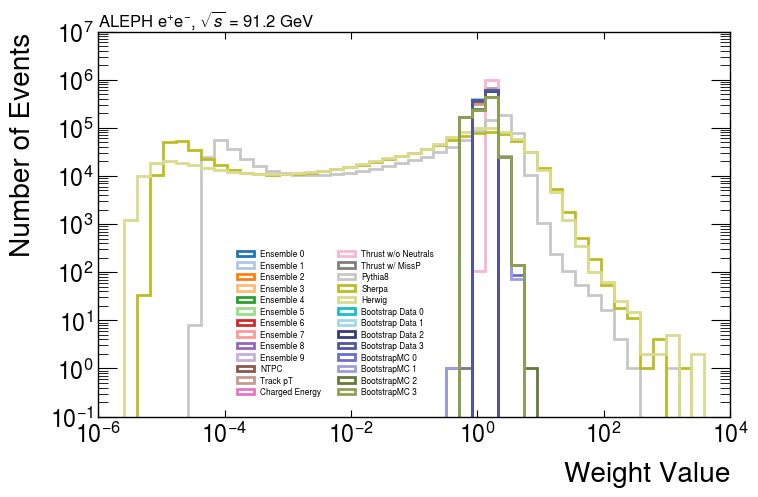

In [11]:
# plot
fig, ax = plt.subplots(figsize=(8, 5))
# long color cycle
colors = list(plt.cm.tab20.colors) + list(plt.cm.tab20b.colors) + list(plt.cm.tab20c.colors)
color_cycle = itertools.cycle(colors)

# plot weights
loopOverWeights = [
    ["Ensemble", np.squeeze(ensemble_weights, axis=0)],
    ["Systematic", systematic_weights],
    ["Theory", theory_weights],
    ["Bootstrap Data", np.squeeze(bootstrap_weights_data, axis=0)],
    ["BootstrapMC", np.squeeze(bootstrap_weights_mc, axis=0)]    
]
bins = np.logspace(-6, 4, 50)
theory_weights_order_iter = iter(theory_weights_order)
systematic_weights_order_iter = iter(err_list[4][0])
for key, weightList in loopOverWeights:
    for iW, weights in enumerate(weightList):
        label = f"{key} {iW}"
        if key == "Theory":
            label = next(theory_weights_order_iter)
        if key == "Systematic":
            label = next(systematic_weights_order_iter)
        ax.hist(weights.flatten(), bins=bins, label=label, histtype='step', color=next(color_cycle), lw=2)

ax.set_xlabel("Weight Value")
ax.set_ylabel("Number of Events")
ax.set_yscale("log")
ax.set_xscale("log")
ax.text(0, 1, r"ALEPH e$^{+}$e$^{-}$, $\sqrt{s}$ = 91.2 GeV", transform=ax.transAxes, ha='left', va='bottom', fontsize=12)
ax.legend(ncol=2, fontsize=6, bbox_to_anchor=(0.2, 0.02), loc="lower left")
plt.savefig("logtau_unifold_weights.pdf", bbox_inches='tight')
plt.show()

In [12]:
# check the uncertainty components statistical, experimental systematic, theoretical systematic versus the aleph publication
unifoldForComparison = np.stack([
    errors['logtau'][f'unifold_aleph_ensemble0']['total'], # total
    errors['logtau'][f'unifold_aleph_ensemble0']['nominal_stat_uncertainty'], # statistical -> note that the full statistical uncertainty includes the bootstrap uncertainty (bootstrap_data_err, bootstrap_data_mc)
    errors['logtau'][f'unifold_aleph_ensemble0']['total_exp_systematic_error'], # experimental systematic
    errors['logtau'][f'unifold_aleph_ensemble0']['total_theory_error'], # theoretical systematic
], axis=1)
alephForComparison = np.concatenate([
    aleph["aleph_log_thrust_errs"].reshape(-1, 1), # total
    aleph["aleph_log_thrust_errs_individual"][:, 0].reshape(-1, 1), # statistical
    aleph["aleph_log_thrust_errs_individual"][:, 1].reshape(-1, 1), # experimental systematic
    aleph["aleph_log_thrust_errs_individual"][:, 2].reshape(-1, 1), # experimental systematic
], axis=1)
ratio = unifoldForComparison/alephForComparison
# print(ratio)
table = np.concatenate([aleph["aleph_log_midbins"].reshape(-1, 1), ratio], axis=1)

# Convert the table to a pandas DataFrame for better formatting
# Define column names
columns = ["Bin Center", "Ratio Total Error", "Ratio Statistical", "Ratio Experimental Syst.", "Ratio Theory Syst."]
# Create a DataFrame
df = pd.DataFrame(table, columns=columns)
# Print the DataFrame as a table
print(df.to_string(index=False, float_format="{:.6f}".format))


 Bin Center  Ratio Total Error  Ratio Statistical  Ratio Experimental Syst.  Ratio Theory Syst.
  -5.302585           1.427431           1.028398                  0.747669           -5.124636
  -4.258597           1.700413           0.902348                  2.606661            1.409529
  -3.709290           1.023346           0.882374                  5.572714            0.763975
  -3.362717           4.364868           0.928078                  3.838659           -4.505071
  -3.107304           4.420868           0.945782                  2.478077           -4.854254
  -2.904571           2.304046           0.951022                  3.182927           -2.186707
  -2.736335           1.261626           0.956945                  3.010487           -0.924781
  -2.592494           1.790290           0.939088                  2.319280            1.736615
  -2.466837           1.608584           0.954053                  2.551601            1.519429
  -2.355265           1.284323          

/tmp/ipykernel_1502062/3354761827.py:41: RuntimeWarning: invalid value encountered in divide
  inPlots["total"] = {"plotType": "stairs", "x": bins, "y": total_err / nominal[0], "color": None, "label": "Unifold Total Error", "ls":"-"}
/tmp/ipykernel_1502062/3354761827.py:45: RuntimeWarning: invalid value encountered in divide
  inPlots[f"component_{i}"] =  {"plotType": "stairs", "x": bins, "y": individual[:,i] / nominal[0], "color":  next(color_cycle), "label": individualErrorLabelOrder[i], "ls": "-"}
/tmp/ipykernel_1502062/3354761827.py:48: RuntimeWarning: invalid value encountered in divide
  ratio_denom = [[total_err/nominal[0]], [errors[key][f"unifold_aleph_ensemble0"]["total"] / plots[key][f"unifold_aleph_ensemble0"][0]]]


No ratio plot for aleph


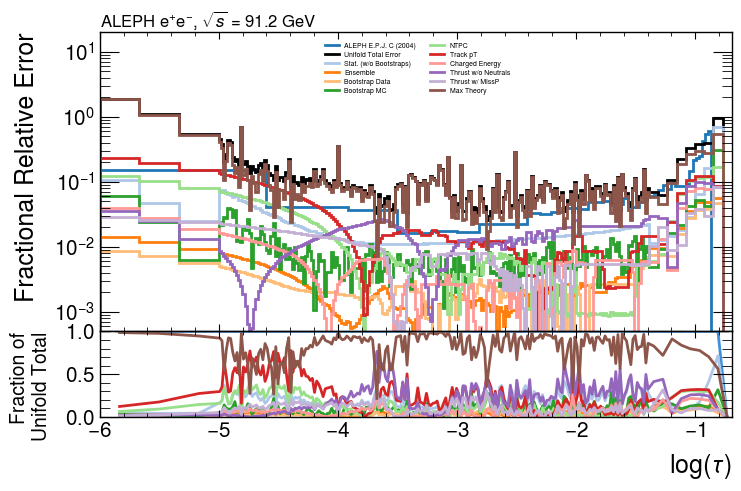

No ratio plot for aleph


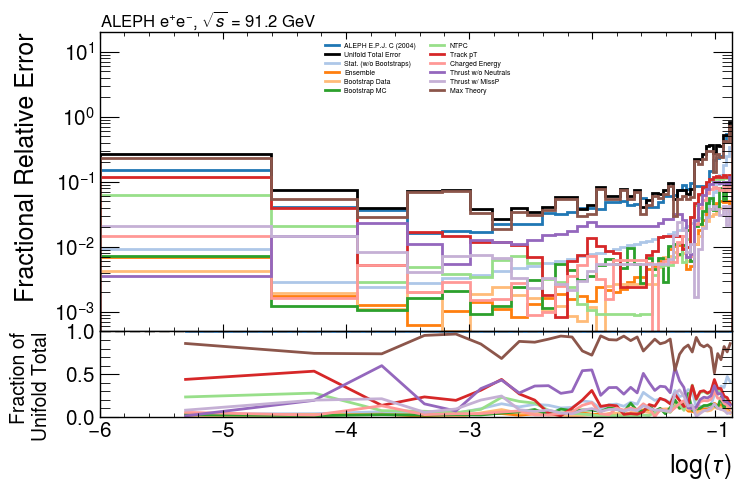

In [13]:
for key, val in conf.items():
    for binType in ["nominal", "aleph"]:
        
        # bins
        bins = val["bins"] if binType == "nominal" else val["aleph"]["bins"]
        binwidths = bins[1:] - bins[:-1]
        bin_centers = (bins[:-1] + bins[1:]) / 2
        
        # style
        style = {
            "legend_loc" : "upper left",
            "legend_bbox" : (0.34, 1.0),
            "legend_ncol" : 2,
            "legend_fontsize" : 5,
            "ax1_ylabel" : "Fractional Relative Error",
            "ax1_yscale" : val["ax1_yscale"],
            "ax2_xlabel" : val["ax2_xlabel"],
            "ax2_xscale" : val["ax2_xscale"],
            "ax2_ylabel" : f'Fraction of\nUnifold Total',
            "ax1_ylim" : [5*10**-4, 2*10**1], #[0.5*10**-6, 5*10**-1],
            "bins" : bins,
            "ax2_ylim" : [0,1],
            "figsize" : (8, 5), # (4,4)
            "header_fontsize" : 12, # 8
        }
        
        # nominal
        nominal = plots[key][f"unifold_{binType}_ensemble0"]

        # pick up the errors
        total_err = errors[key][f"unifold_{binType}_ensemble0"]["total"]
        individual = np.abs(errors[key][f"unifold_{binType}_ensemble0"]["individual"])

        # 20 unique colors
        colors = plt.cm.tab20.colors  
        color_cycle = itertools.cycle(colors)

        # inPlots
        inPlots = {}
        inPlots["aleph"] = {"plotType": "stairs", "x": val["aleph"]["bins"], "y": val["aleph"]["yerr"] / val["aleph"]["y"], "color": next(color_cycle), "label": 'ALEPH E.P.J. C (2004)', "ls":"-", "noratio":True} # "green"
        inPlots["total"] = {"plotType": "stairs", "x": bins, "y": total_err / nominal[0], "color": None, "label": "Unifold Total Error", "ls":"-"}
        
        # other variations
        for i in range(individual.shape[1]):
            inPlots[f"component_{i}"] =  {"plotType": "stairs", "x": bins, "y": individual[:,i] / nominal[0], "color":  next(color_cycle), "label": individualErrorLabelOrder[i], "ls": "-"}
        
        # ratio denominator using the total error
        ratio_denom = [[total_err/nominal[0]], [errors[key][f"unifold_aleph_ensemble0"]["total"] / plots[key][f"unifold_aleph_ensemble0"][0]]]

        fig, (ax1, ax2) = plotThrust(style, inPlots, ratio_denom, epsilon = 1e-10)
        # plt.savefig(f"{key}_unifold_binning_{binType}_uncertaintyBreakdown.pdf", bbox_inches='tight')
        plt.show()
        plt.close()

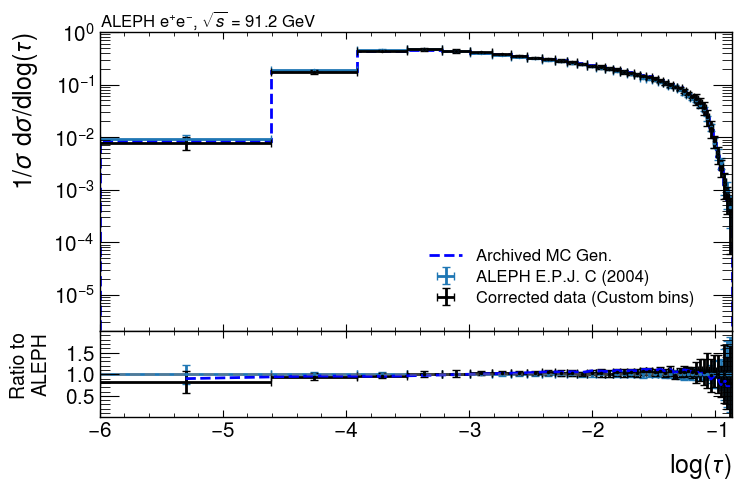

/global/u1/b/badea/aleph/unfold-ee-logtau/Plotting/Utils.py:172: RuntimeWarning: invalid value encountered in divide
  ratio = A / B
/global/u1/b/badea/aleph/unfold-ee-logtau/Plotting/Utils.py:179: RuntimeWarning: invalid value encountered in divide
  (A_err / A)**2 + (B_err / B)**2


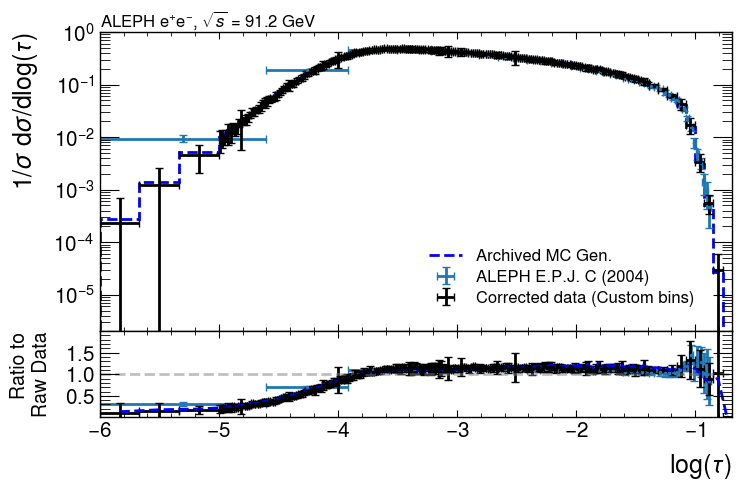

/global/u1/b/badea/aleph/unfold-ee-logtau/Plotting/Utils.py:172: RuntimeWarning: invalid value encountered in divide
  ratio = A / B
/global/u1/b/badea/aleph/unfold-ee-logtau/Plotting/Utils.py:179: RuntimeWarning: invalid value encountered in divide
  (A_err / A)**2 + (B_err / B)**2


No ratio plot for mc_genBefore


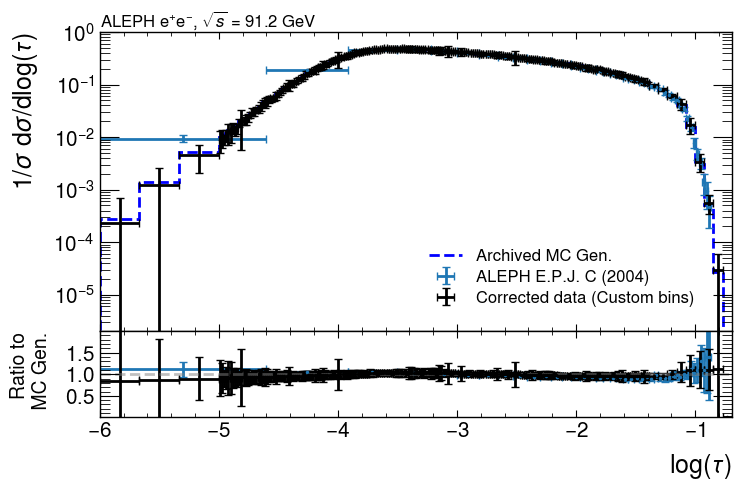

No ratio plot for unifold


/global/u1/b/badea/aleph/unfold-ee-logtau/Plotting/Utils.py:172: RuntimeWarning: invalid value encountered in divide
  ratio = A / B


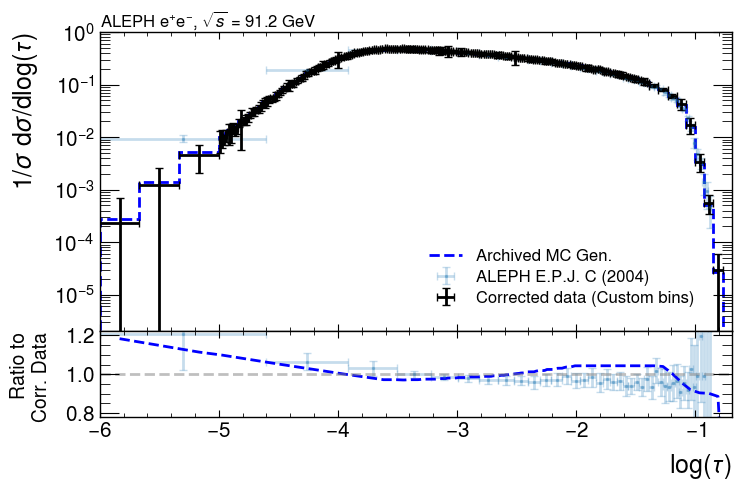

In [14]:
for key, val in conf.items():
    for ratioTo in ["aleph", "data", "genBefore", "unifold"]:

        # bins
        binType = "aleph" if ratioTo == "aleph" else "nominal"
        bins = val["aleph"]["bins"] if ratioTo == "aleph" else val["bins"]
        binwidths = bins[1:] - bins[:-1]
        bin_centers = (bins[:-1] + bins[1:]) / 2
        
        # ratio limit
        ax2_ylim = val["ax2_ylim"]
        ax2_xlim = None
        # define denominator for ratio
        if ratioTo == "aleph":
            ratio_denom = [val["aleph"]["y"], val["aleph"]["yerr"]]
            ratio_denom = [ratio_denom] # expect list of lists
            ax2_ylabel = f'Ratio to\nALEPH'
            # print(plots[key][f"unifold_{binType}_ensemble0"][0]/val["aleph"]["y"])
            # print()
        elif ratioTo == "data":
            ratio_denom = [plots[key][f"data_{binType}"], plots[key][f"data_aleph"]]
            ax2_ylabel = f'Ratio to\nRaw Data'
        elif ratioTo == "genBefore":
            ratio_denom = [plots[key][f"mc_genBefore_{binType}"], plots[key][f"mc_genBefore_aleph"]]
            ax2_ylabel = f'Ratio to\n MC Gen.'
        elif ratioTo == "unifold":
            ratio_denom = [plots[key][f"unifold_{binType}_ensemble0"], plots[key][f"unifold_aleph_ensemble0"]]
            ax2_ylabel = f'Ratio to\nCorr. Data'
            ax2_ylim = [0.78, 1.22]
            ax2_xlim = None # [-3.5, -0.75]
        else:
            print("nothing")
        
        # style
        style = {
            "legend_loc" : val["legend"],
            "legend_bbox" : val["legend_bbox"],
            "legend_ncol" : 1,
            "legend_fontsize" : 12, # 9
            "ax1_ylabel" : val["ax1_ylabel"],
            "ax1_yscale" : val["ax1_yscale"],
            "ax2_xlabel" : val["ax2_xlabel"],
            "ax2_xscale" : val["ax2_xscale"],
            "ax2_ylabel" : ax2_ylabel,
            "ax1_ylim" : val["ax1_ylim"],
            "bins" : bins,
            "ax2_ylim" : ax2_ylim,
            "ax2_xlim" : ax2_xlim,
            "figsize" : (8, 5), # (4,4) 
            "header_fontsize" : 12, # 8
        }
        # print(bins)

        # inPlots
        inPlots = {}
        inPlots["aleph"] = {"plotType": "errorbar", "x": val["aleph"]["x"], "y": val["aleph"]["y"], "color": colors[0], "label": 'ALEPH E.P.J. C (2004)', "xerr":val["aleph"]["xerr"], "yerr":val["aleph"]["yerr"], "alpha":0.25 if ratioTo=="unifold" else 1}
        # if ratioTo == "genBefore":
        #     inPlots["unifold_aleph"] = {"plotType": "errorbar", "x": val["aleph"]["x"], "y": plots[key][f"unifold_aleph_ensemble0"][0], "color": "black", "label": "Corrected data (ALEPH bins)", "xerr":val["aleph"]["xerr"], "yerr":errors[key][f"unifold_aleph_ensemble0"]["total"]}
        inPlots["unifold"] = {"plotType": "errorbar", "x": bin_centers, "y": plots[key][f"unifold_{binType}_ensemble0"][0], "color": "black", "label": "Corrected data (Custom bins)", "xerr":binwidths/2, "yerr":errors[key][f"unifold_{binType}_ensemble0"]["total"], "noratio" : True if ratioTo == "unifold" else False}
        # if not ratioTo == "aleph":
        #     inPlots["unifold"].update({
        #         "markersize":0.5,
        #         "lw" : 0.5,
        #         "capsize" : 0.5
        #         })
        # inPlots["data"] = {"plotType": "stairs", "x": bins, "y": plots[key][f"data_{binType}"][0], "color": "gray", "label": "Uncorrected data", "ls":"-"}
        # inPlots["mc_reco"] = {"plotType": "stairs", "x": bins, "y": plots[key][f"mc_reco_{binType}"][0], "color": "orange", "label": "Archived MC Reco.", "ls":"-"}
        inPlots["mc_genBefore"] = {"plotType": "stairs", "x": bins, "y": plots[key][f"mc_genBefore_{binType}"][0], "color": "blue", "label": "Archived MC Gen.", "ls":"--", "noratio" : True if ratioTo == "genBefore" else False}
        # theory comparison plots
        # inPlots["Pythia8"] = {"plotType": "stairs", "x": bins, "y": plots[key][f"Pythia8_{binType}"][0], "color": "orange", "label": "Pythia 8", "ls":"--"} # , "noratio" : True if ratioTo == "genBefore" else False}
        # inPlots["Herwig"] = {"plotType": "stairs", "x": bins, "y": plots[key][f"Herwig_{binType}"][0], "color": "purple", "label": "Herwig", "ls":"--"} #, "noratio" : True if ratioTo == "genBefore" else False}
        # inPlots["Sherpa"] = {"plotType": "stairs", "x": bins, "y": plots[key][f"Sherpa_{binType}"][0], "color": "green", "label": "Sherpa", "ls":"--"} #, "noratio" : True if ratioTo == "genBefore" else False}
        
        # make figure
        fig, (ax1, ax2) = plotThrust(style, inPlots, ratio_denom, epsilon = 1e-10)

        # plt.savefig(f"{key}_unifold_ratioTo_{ratioTo}.pdf", bbox_inches='tight')
        # plt.savefig(f"boostPlots/{key}_unifold_ratioTo_{ratioTo}_ALEPHBins.pdf", bbox_inches='tight')
        plt.savefig(f"boostPlots/{key}_unifold_ratioTo_{ratioTo}_CustomBins.pdf", bbox_inches='tight')
        # plt.savefig(f"boostPlots/{key}_unifold_ratioTo_{ratioTo}_CustomBinsTheoryComparison.pdf", bbox_inches='tight')
        # plt.savefig(f"boostPlots/{key}_unifold_ratioTo_{ratioTo}_NoUniFold.pdf", bbox_inches='tight')
        plt.show()
        plt.close()
        

